In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import zipfile
import os
from pathlib import Path
import re
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [2]:
# create a path to the pokemon image directory
train_dir = 'images/images'
train_path = Path(train_dir)

# create a dataframe with the name and filepath of each pokemon
files = list(train_path.glob('*.png'))
names = [os.path.split(x)[1] for x in list(train_path.glob('*.png'))]
image_df = pd.concat([pd.Series(names, name='Name'), pd.Series(files, name='Filepath').astype(str)], axis=1)
image_df['Name'] = image_df['Name'].apply(lambda x: re.sub(r'\.\w+$', '', x))
image_df.head()

# load in csv with the name, primary type, and secondary type of each pokemon
label_df = pd.read_csv('pokemon.csv')

# merge image_df with label_df
df = image_df.merge(label_df, on='Name')

# drop the Name and Type2 columns
df = df.drop(['Name', 'Type2', 'Gen', 'Starter'], axis=1) 
df.head()

,Filepath,Type1
0,images/images/barbaracle.png,Rock
1,images/images/hoppip.png,Grass
2,images/images/kangaskhan.png,Normal
3,images/images/weavile.png,Dark
4,images/images/greninja.png,Water


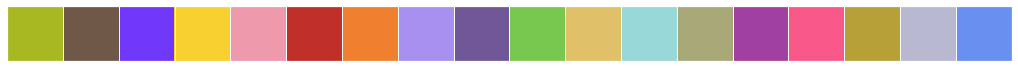

In [3]:
custom_colors = {
    'Bug': '#a8b820',
    'Dark': '#705848',
    'Dragon': '#7038f8',
    'Electric': '#f8d030',
    'Fairy': '#ee99ac',
    'Fighting': '#c03028',
    'Fire': '#f08030',
    'Flying': '#a890f0', 
    'Ghost': '#705898',
    'Grass': '#78c850',
    'Ground': '#e0c068',
    'Ice': '#98d8d8',
    'Normal': '#a8a878',
    'Poison': '#a040a0',
    'Psychic': '#f85888',
    'Rock': '#b8a038',
    'Steel': '#b8b8d0',
    'Water': '#6890f0'
}

sns.set(font_scale=1.25) 
sns.set_palette(sns.color_palette(custom_colors.values()))
sns.palplot(sns.color_palette(custom_colors.values()),size=1)

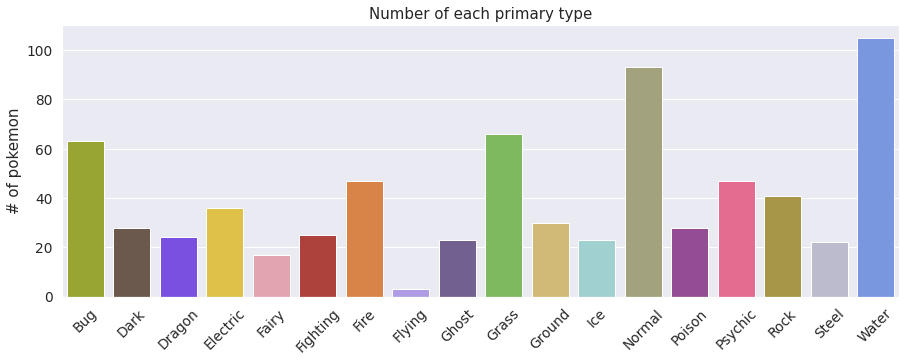

In [4]:
# find the number of each type of pokemon 
type1 = list(custom_colors.keys())
type1_nums = []
for type in type1:
  type1_nums.append(sum(df['Type1']==type))

type1_data = pd.DataFrame(data=type1_nums, index=type1, columns=['# of pokemon'])

# plot number of each type of pokemon
plt.figure(figsize=(15,5))
plt.title('Number of each primary type')
ax = sns.barplot(x=type1_data.index, y='# of pokemon', data=type1_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")
plt.show()

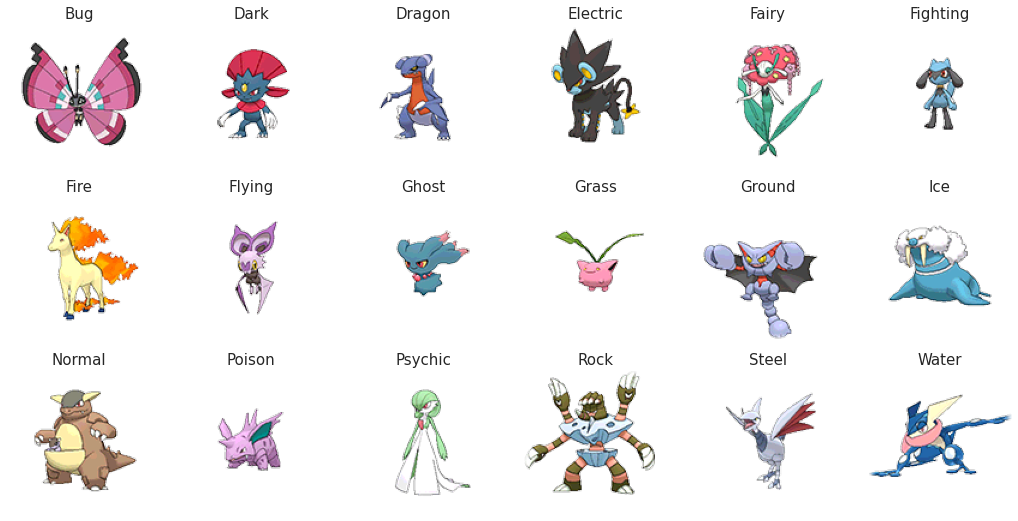

In [5]:


# determine the indices of the first occurrance of each pokemon type
first_row_indices = []
for type in type1:
  first_row_indices.append(df[df['Type1']==type].index[0])

# obtain the image from the filepath at the determined indices
imgs = []
for index in first_row_indices:
  imgs.append(mpimg.imread(df.iat[index, 0]))

# output the images 
f, axarr = plt.subplots(3,6, figsize=(18,9))  
count = 0
for r in range(3):
  for c in range(6):
    axarr[r,c].imshow(imgs[count])
    axarr[r,c].set_title(type1[count])
    axarr[r,c].set_axis_off()
    count += 1 
plt.show()



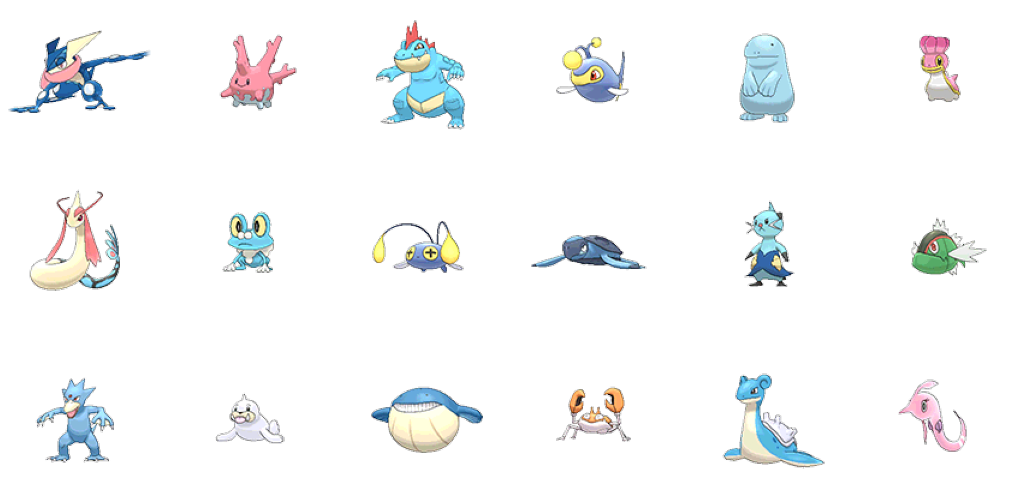

In [6]:


# determine indices
water_indices = []
for i in range(len(df.index)):
  if df.iat[i,1]=='Water':      
    water_indices.append(i)

# obtain images from the filepaths at the determined indices
water_imgs = []
for index in water_indices:
  water_imgs.append(mpimg.imread(df.iat[index, 0]))

# output images
f, axarr = plt.subplots(3,6, figsize=(18,9))  
count = 0
for r in range(3):
  for c in range(6):
    axarr[r,c].imshow(water_imgs[count])
    axarr[r,c].set_axis_off()
    count += 1 
plt.show()



In [7]:


# limit data to Fire and Water types
df = df.query("Type1 == 'Fire' | Type1 == 'Water'")

print("Number of water-types:", len(df[df['Type1'] == 'Water']))
print("Number of fire-types:", len(df[df['Type1'] == 'Fire']))



Number of water-types: 105
Number of fire-types: 47


In [8]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

train_gen = keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,   # split the dataset into a training set and a validation set in an 8:2 ratio
    rescale=1./255          # rescale the rgb values to fit between 0 and 1 
)

train_data = train_gen.flow_from_dataframe(
    df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(120, 120),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    seed=1,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(120, 120),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    seed=1,
    subset='validation'
)

Found 122 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


In [9]:
img_input = layers.Input(shape=(120, 120, 4))

x = layers.Conv2D(filters=64, kernel_size=(8, 8), activation='relu')(img_input)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(filters=128, kernel_size=(8, 8), activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(filters=256, kernel_size=(8, 8), activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(units=1, activation='sigmoid')(x)

model = keras.Model(inputs=img_input, outputs=output)

model.compile(
    optimizer='adam',                 
    loss='binary_crossentropy',
    metrics=['acc', keras.metrics.AUC()]
)

# print model layers
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 4)]     0         
                                                                 
 conv2d (Conv2D)             (None, 113, 113, 64)      16448     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 49, 49, 128)       524416    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 256)       209740

2022-02-18 18:40:43.454071: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=32,
    epochs=50,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/50
4/4 [==============================] - 8s 2s/step - loss: 0.9821 - acc: 0.5984 - auc: 0.6027 - val_loss: 0.7354 - val_acc: 0.6333 - val_auc: 0.8612 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 7s 2s/step - loss: 0.7072 - acc: 0.7049 - auc: 0.4788 - val_loss: 0.6608 - val_acc: 0.6333 - val_auc: 0.9689 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 8s 2s/step - loss: 0.5675 - acc: 0.7049 - auc: 0.6812 - val_loss: 0.5259 - val_acc: 0.6333 - val_auc: 0.9713 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - 8s 2s/step - loss: 0.4397 - acc: 0.7049 - auc: 0.8871 - val_loss: 0.4288 - val_acc: 0.6333 - val_auc: 0.9569 - lr: 0.0010
Epoch 5/50
4/4 [==============================] - 7s 2s/step - loss: 0.3910 - acc: 0.7049 - auc: 0.9231 - val_loss: 0.3824 - val_acc: 0.6333 - val_auc: 0.9474 - lr: 0.0010
Epoch 6/50
4/4 [==============================] - 7s 2s/step - loss: 0.3696 - acc: 0.7049 - auc: 0.9317 - val_loss: 0.3735 - val_acc: 0.8000

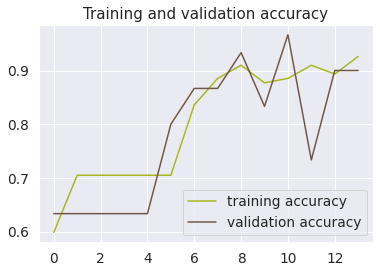

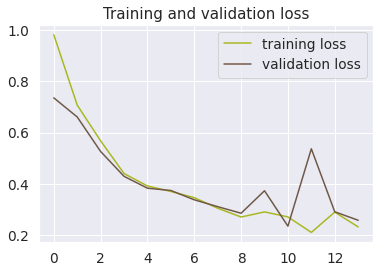

In [11]:
# retrieve accuracy history on training and validation data
acc = history.history['acc']
val_acc = history.history['val_acc']

# retrieve loss history on training and validation data
loss = history.history['loss']
val_loss = history.history['val_loss']

# get number of epochs
epochs = range(len(acc))

# plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

In [12]:
# get true labels
true_labels = val_data.labels

# get predictions in the form of probablities 
predictions = model.predict(val_data)

# convert probablities into binary values 
predictions = [1 if n >= 0.5 else 0 for n in predictions]
print("Model predictions: "+str(predictions))
print("Actual labels:     "+str(true_labels))

# determine filepaths of misclassified pokemon
num_misclasssified = 0
misclassified_filepaths = []
correctness = []
for pred, label, i in zip(predictions, true_labels, range(len(predictions))):
  misclassified_filepaths.append(val_data.filepaths[i])
  if pred != label:
    correctness.append('incorrect')
    num_misclasssified += 1
  else:
    correctness.append('correct')

print("# of misclassified pokemon: "+str(num_misclasssified))

1/1 [==============================] - 0s 375ms/step
Model predictions: [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]
Actual labels:     [1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1]
# of misclassified pokemon: 15


In [13]:
print("Percent correct: ", (len(correctness) / (num_misclasssified + len(correctness))))

Percent correct:  0.6666666666666666


In [14]:
# get true labels
true_labels = val_data.labels

# get predictions in the form of probablities 
predictions = model.predict(val_data)

# convert probablities into binary values 
predictions = [1 if n >= 0.5 else 0 for n in predictions]
print("Model predictions: "+str(predictions))
print("Actual labels:     "+str(true_labels))

# determine filepaths of misclassified pokemon
num_misclasssified = 0
misclassified_filepaths = []
correctness = []
for pred, label, i in zip(predictions, true_labels, range(len(predictions))):
  misclassified_filepaths.append(val_data.filepaths[i])
  if pred != label:
    correctness.append('incorrect')
    num_misclasssified += 1
  else:
    correctness.append('correct')

print("# of misclassified pokemon: "+str(num_misclasssified))

1/1 [==============================] - 0s 348ms/step
Model predictions: [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]
Actual labels:     [1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1]
# of misclassified pokemon: 17
